In [531]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

In [532]:
ONLY_CS = True
EXCLUDE_TRANSFER = True

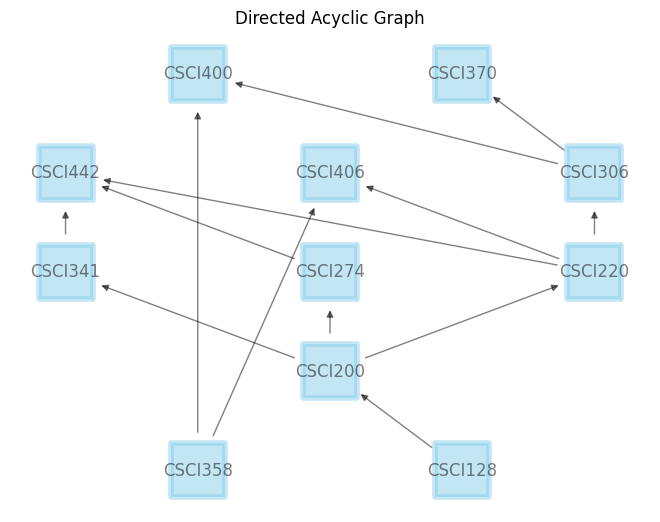

In [533]:
# create dag
reader = pd.read_csv('../dags/dag_simple.csv')
dag = nx.DiGraph()

for i in range(len(reader)):
    dag.add_edge(reader['prereq'][i], reader['class'][i])

for layer, nodes in enumerate(nx.topological_generations(dag)):
    for node in nodes:
        dag.nodes[node]["layer"] = layer

# plot the dag
pos = nx.multipartite_layout(dag,subset_key="layer", align='horizontal')
nx.draw(dag, pos, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=4)
plt.title('Directed Acyclic Graph')
plt.show()

# Eligible

Notes about modifications made: 
- All Summer classes are pushed back to Spring (if taken in Summer, eligible to take in Fall)
- All admittance occurs in Fall or Spring (if taken in Summer, pushed forward to Fall)

In [534]:
taken_df = pd.read_csv('../data/CS_Course_Enrollment_Data_Pivot.csv')

In [535]:
# see only CS students
if ONLY_CS:
    taken_df = taken_df[taken_df['Department'] == "Computer Science"]

# exclude transfer students
if EXCLUDE_TRANSFER:
    taken_df = taken_df[taken_df['Type'] != 'Tran']

# replace CSCI101 with CSCI128
taken_df['Class'] = taken_df['Class'].replace('CSCI101', 'CSCI128')

# add numerical conversion 
UNIQUE_SEM = 5
taken_df['Taken_Num'] = np.select([
    taken_df['Taken_Semester'] == 'Spring',
    taken_df['Taken_Semester'] == 'Summer One',
    taken_df['Taken_Semester'] == 'Summer Two',
    taken_df['Taken_Semester'] == 'Summer',
    taken_df['Taken_Semester'] == 'Fall'
    ], 
    [taken_df['Taken_Year'] * UNIQUE_SEM, 
    taken_df['Taken_Year'] * UNIQUE_SEM + 1, 
    taken_df['Taken_Year'] * UNIQUE_SEM + 2,
    taken_df['Taken_Year'] * UNIQUE_SEM + 3,
    taken_df['Taken_Year'] * UNIQUE_SEM + 4], 
    default = 'UNKNOWN')

taken_df['Admitted_Num'] = np.select([
    taken_df['Admitted_Semester'] == 'Spring',
    taken_df['Admitted_Semester'] == 'Summer One',
    taken_df['Admitted_Semester'] == 'Summer Two',
    taken_df['Admitted_Semester'] == 'Summer',
    taken_df['Admitted_Semester'] == 'Fall'
    ], 
    [taken_df['Admitted_Year'] * UNIQUE_SEM, 
    taken_df['Admitted_Year'] * UNIQUE_SEM + 1, 
    taken_df['Admitted_Year'] * UNIQUE_SEM + 2,
    taken_df['Admitted_Year'] * UNIQUE_SEM + 3,
    taken_df['Admitted_Year'] * UNIQUE_SEM + 4], 
    default = 'UNKNOWN')

taken_df['Taken_Num'] = taken_df['Taken_Num'].astype(int)

In [536]:
assert(len(taken_df[taken_df['Taken_Num'] == 'UNKNOWN']) == 0)
assert(len(taken_df[taken_df['Admitted_Num'] == 'UNKNOWN']) == 0)

In [537]:
# find in-degrees of dag
in_degrees = dict(dag.in_degree())
in_degrees = dict(sorted(in_degrees.items()))

In [538]:
# create carry-through df
carry_through = pd.DataFrame(columns=['Semester_Num'] + list(in_degrees.keys()))

# find uniques
unique_ids = taken_df['id'].unique()
unique_nums = sorted(taken_df['Taken_Num'].unique())
unique_nums += [int(max(unique_nums)) + 1]

for num in unique_nums: 
    temp = [num] + list(in_degrees.values())
    carry_through = pd.concat([carry_through, pd.DataFrame([temp], columns=carry_through.columns)], ignore_index=True)

carry_through = carry_through.astype({'Semester_Num': 'int32'})
carry_through

,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442
0,10089,0,1,1,1,1,1,0,1,2,2,3
1,10090,0,1,1,1,1,1,0,1,2,2,3
2,10091,0,1,1,1,1,1,0,1,2,2,3
3,10092,0,1,1,1,1,1,0,1,2,2,3
4,10094,0,1,1,1,1,1,0,1,2,2,3
5,10095,0,1,1,1,1,1,0,1,2,2,3
6,10098,0,1,1,1,1,1,0,1,2,2,3
7,10099,0,1,1,1,1,1,0,1,2,2,3
8,10100,0,1,1,1,1,1,0,1,2,2,3
9,10103,0,1,1,1,1,1,0,1,2,2,3


In [539]:
def out_calc(G,cl):
    if G.has_node(cl):
        return list(G.successors(cl))
    else:
        return []

In [540]:
# create carry-out df
cols = ['id'] + list(carry_through.columns)
carry_out = pd.DataFrame(columns=cols)

In [541]:
admit_df = taken_df[['id', 'Admitted_Num']].drop_duplicates()

In [542]:
for i in unique_ids: 

    # find admit_num for id
    admit_num = admit_df[admit_df['id'] == i]['Admitted_Num'].values[0]

    # create copy and assign 
    temp_df = carry_through.copy()
    temp_df['id'] = i
    temp_df = temp_df[temp_df['Semester_Num'] >= int(admit_num)]

    # find taken records from taken_df
    taken_temp = taken_df[taken_df['id'] == i]
    taken_temp = taken_temp.sort_values(by='Taken_Num')

    # iterate through taken records
    for index, row in taken_temp.iterrows():
        # affect classes
        affected_classes = out_calc(dag, row['Class']) + [row['Class']] # find classes
        for cl in affected_classes:
             # decrement out-degrees for all semesters after the current semester
            temp_df.loc[temp_df['Semester_Num'] > row['Taken_Num'], cl] -= 1
    
    carry_out = pd.concat([carry_out, temp_df], ignore_index=True)

carry_out

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442
0,147,10089,0,1,1,1,1,1,0,1,2,2,3
1,147,10090,-1,-1,0,0,1,0,0,1,2,2,3
2,147,10091,-1,-1,0,0,1,0,0,1,2,2,3
3,147,10092,-1,-1,0,0,1,0,0,1,2,2,3
4,147,10094,-1,-1,0,0,1,0,0,1,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,7157,10114,0,1,1,1,1,1,0,1,2,2,2
15320,7157,10115,0,1,1,1,1,1,0,1,2,2,2
15321,7157,10118,0,1,1,1,1,1,0,1,2,2,2
15322,7157,10119,0,1,1,1,1,1,0,1,2,2,2


In [543]:
# convert Semseter_Num as int back into year and semester
carry_out = carry_out.astype({'Semester_Num': 'int32'})
carry_out['Year'] = carry_out['Semester_Num'] // UNIQUE_SEM
carry_out['Semester'] = carry_out['Semester_Num'] % UNIQUE_SEM

carry_out['Semester'] = np.select([
    carry_out['Semester'] == 0,
    carry_out['Semester'] == 1,
    carry_out['Semester'] == 2,
    carry_out['Semester'] == 3, 
    carry_out['Semester'] == 4
    ], 
    ['Spring', 'Summer One', 'Summer Two', 'Summer', 'Fall'], 
    default = 'UNKNOWN')

# clean and concat
carry_out['Year_Semester'] = carry_out['Semester'].astype(str) + ' ' + carry_out['Year'].astype(str)
carry_out = carry_out.drop(columns=['Year', 'Semester'])
carry_out

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,Year_Semester
0,147,10089,0,1,1,1,1,1,0,1,2,2,3,Fall 2017
1,147,10090,-1,-1,0,0,1,0,0,1,2,2,3,Spring 2018
2,147,10091,-1,-1,0,0,1,0,0,1,2,2,3,Summer One 2018
3,147,10092,-1,-1,0,0,1,0,0,1,2,2,3,Summer Two 2018
4,147,10094,-1,-1,0,0,1,0,0,1,2,2,3,Fall 2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,7157,10114,0,1,1,1,1,1,0,1,2,2,2,Fall 2022
15320,7157,10115,0,1,1,1,1,1,0,1,2,2,2,Spring 2023
15321,7157,10118,0,1,1,1,1,1,0,1,2,2,2,Summer 2023
15322,7157,10119,0,1,1,1,1,1,0,1,2,2,2,Fall 2023


# Plots and Whatnots

In [544]:
carry_out

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,Year_Semester
0,147,10089,0,1,1,1,1,1,0,1,2,2,3,Fall 2017
1,147,10090,-1,-1,0,0,1,0,0,1,2,2,3,Spring 2018
2,147,10091,-1,-1,0,0,1,0,0,1,2,2,3,Summer One 2018
3,147,10092,-1,-1,0,0,1,0,0,1,2,2,3,Summer Two 2018
4,147,10094,-1,-1,0,0,1,0,0,1,2,2,3,Fall 2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,7157,10114,0,1,1,1,1,1,0,1,2,2,2,Fall 2022
15320,7157,10115,0,1,1,1,1,1,0,1,2,2,2,Spring 2023
15321,7157,10118,0,1,1,1,1,1,0,1,2,2,2,Summer 2023
15322,7157,10119,0,1,1,1,1,1,0,1,2,2,2,Fall 2023


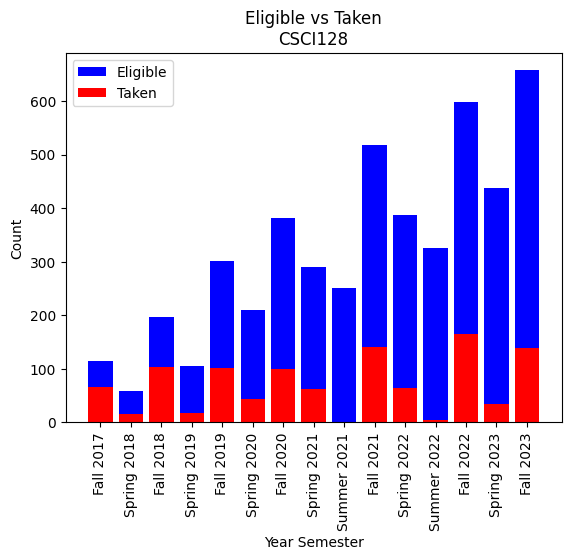

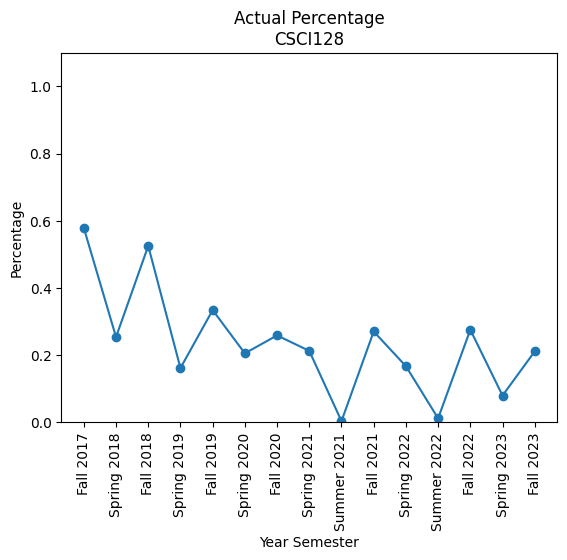

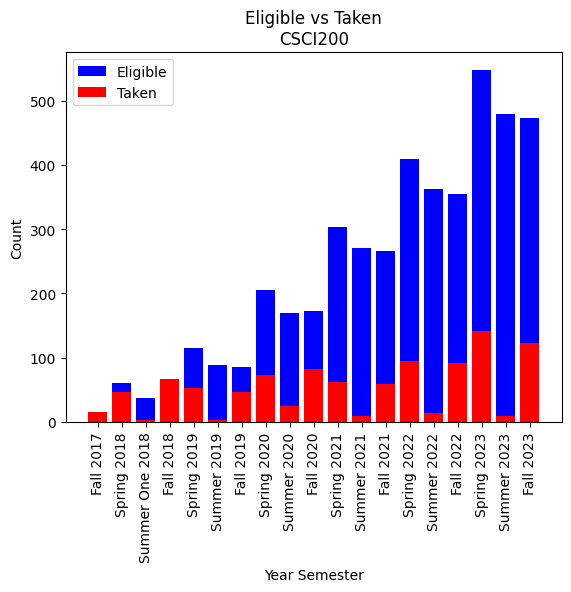

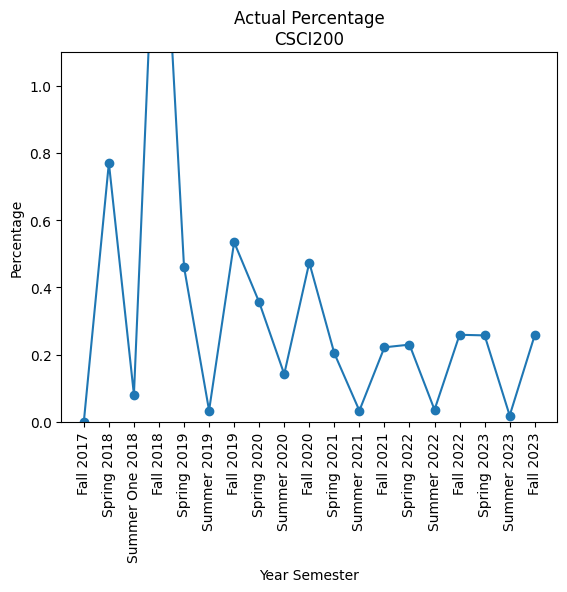

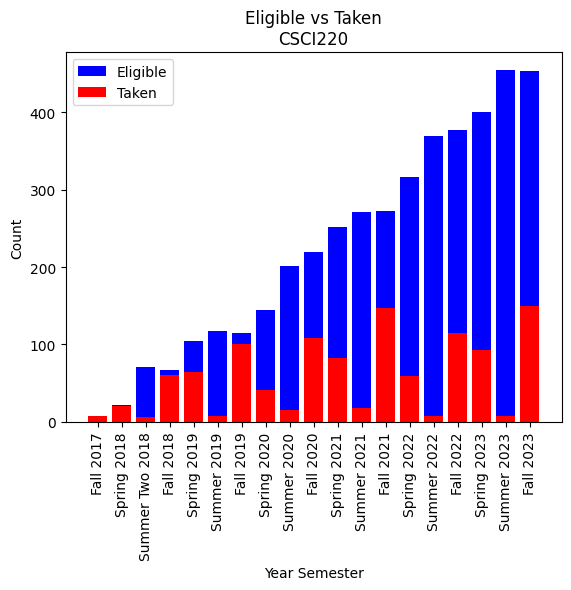

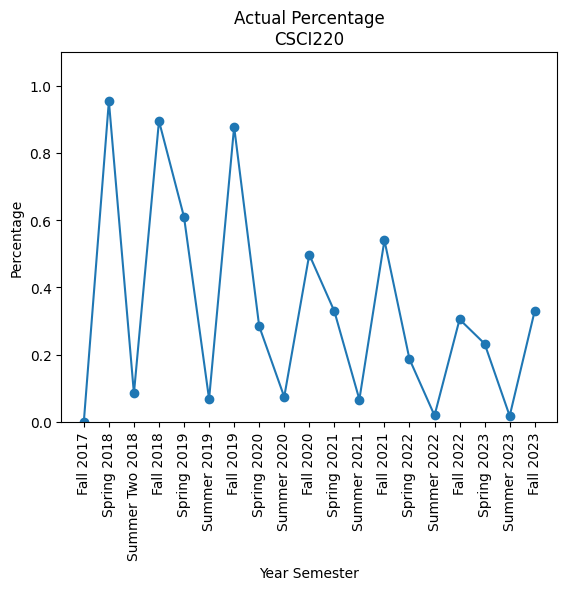

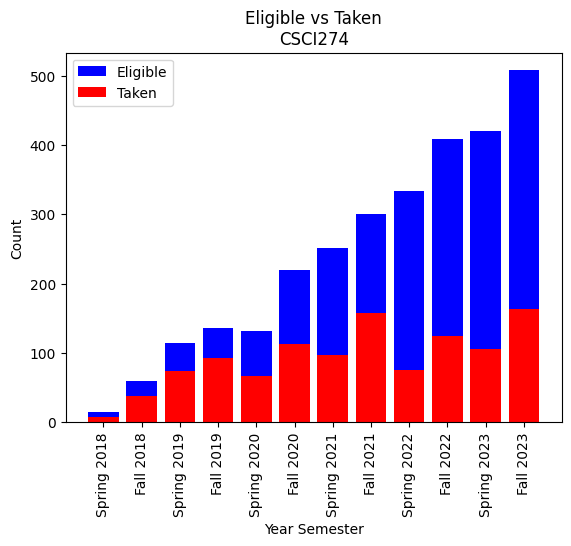

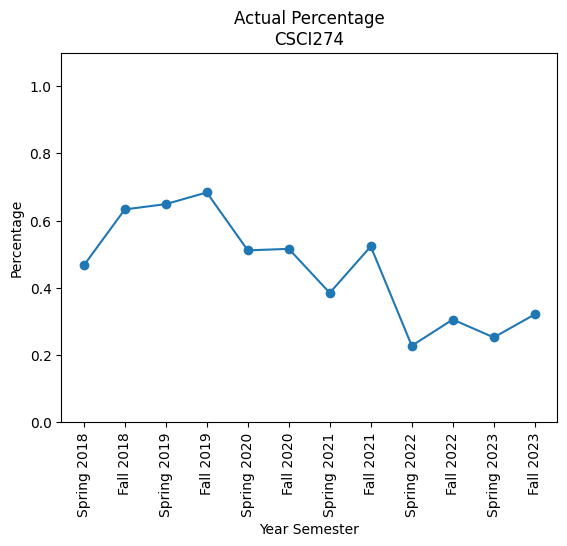

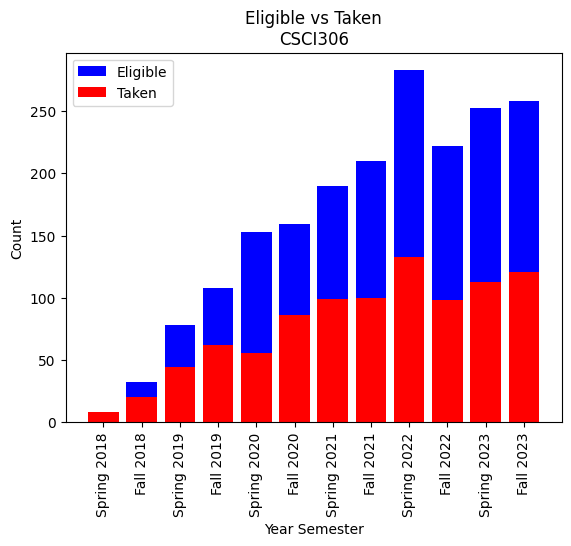

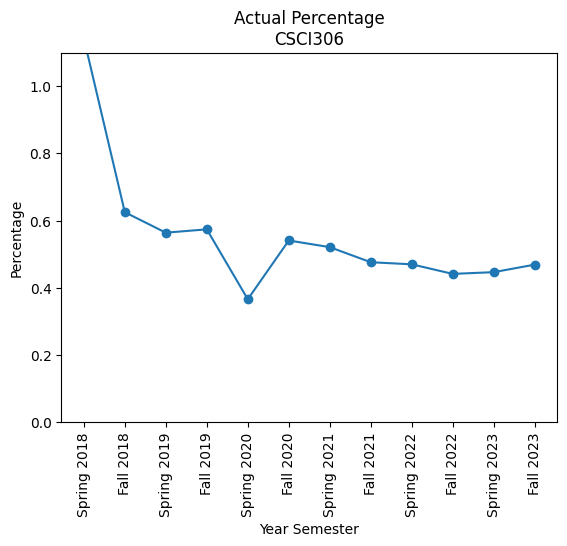

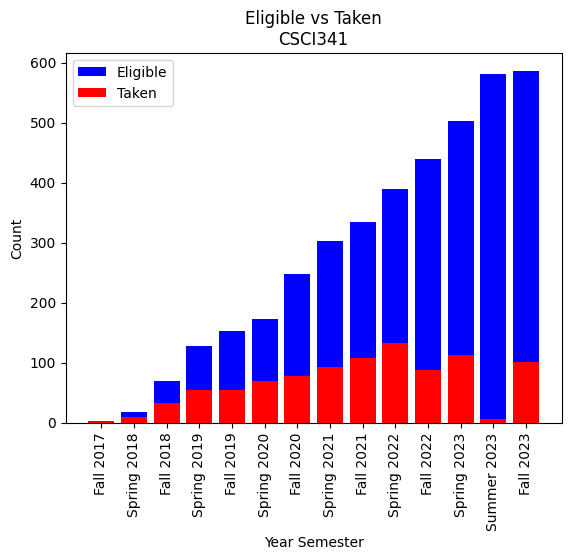

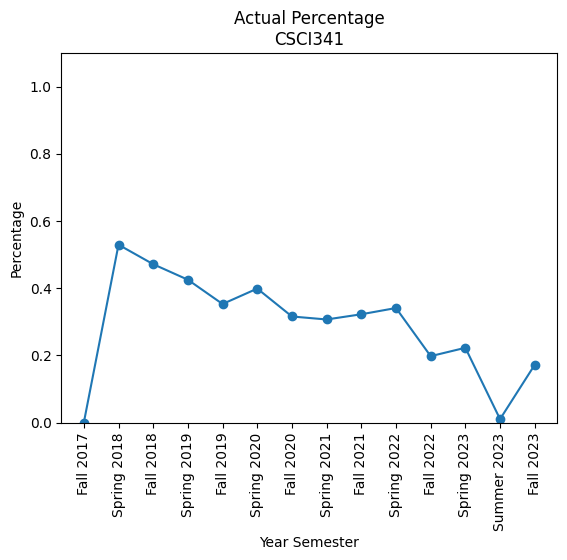

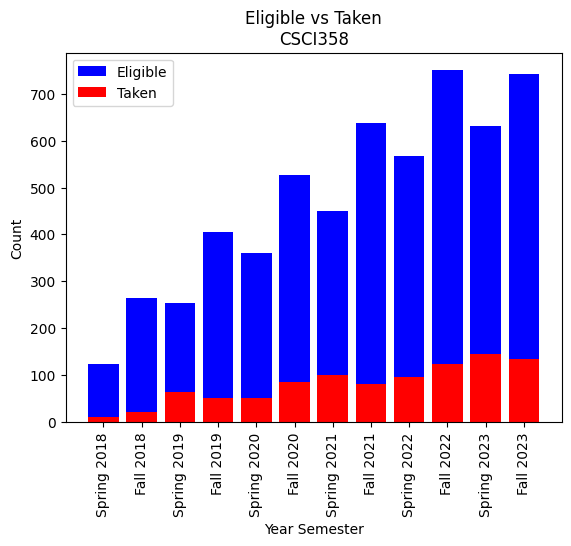

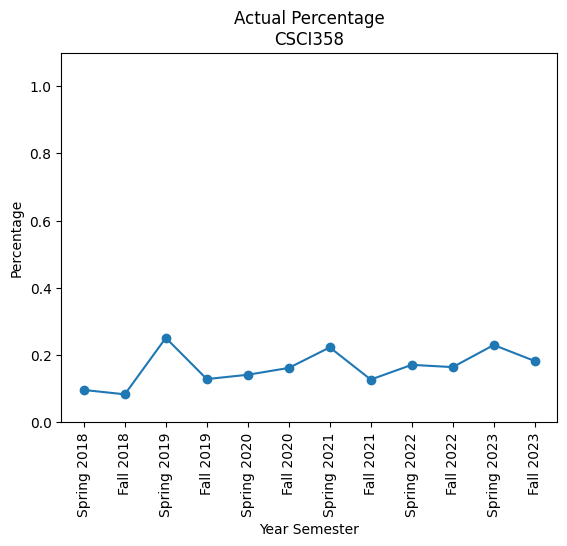

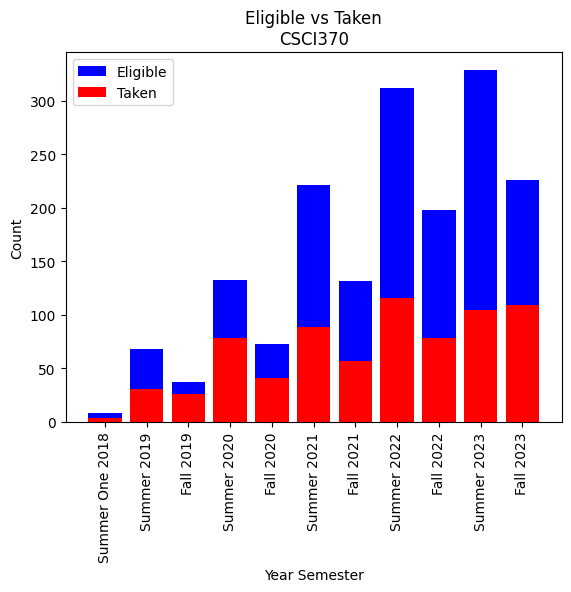

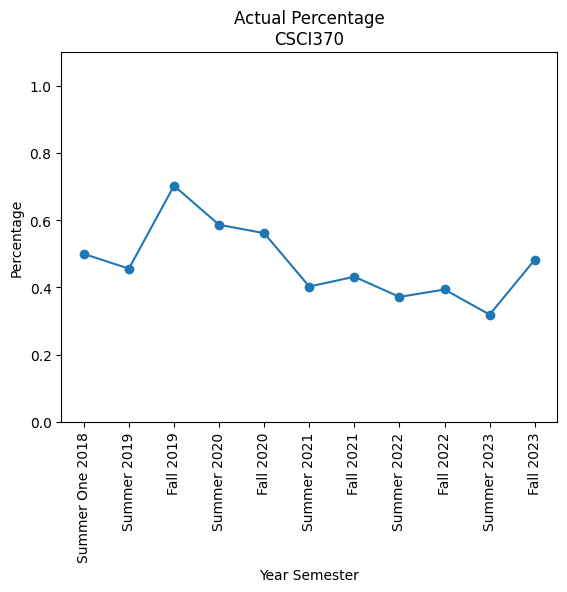

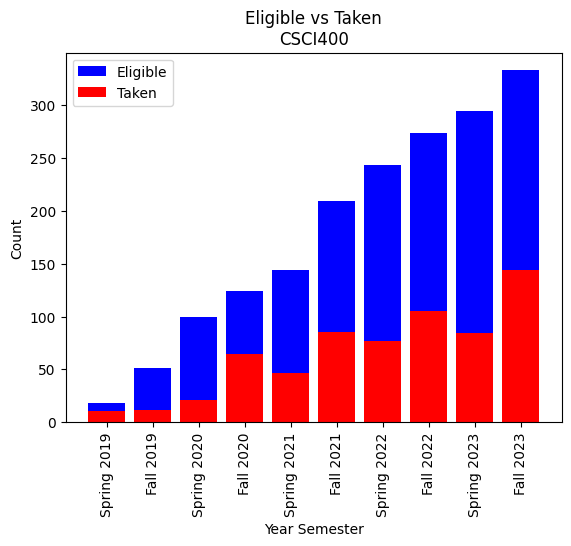

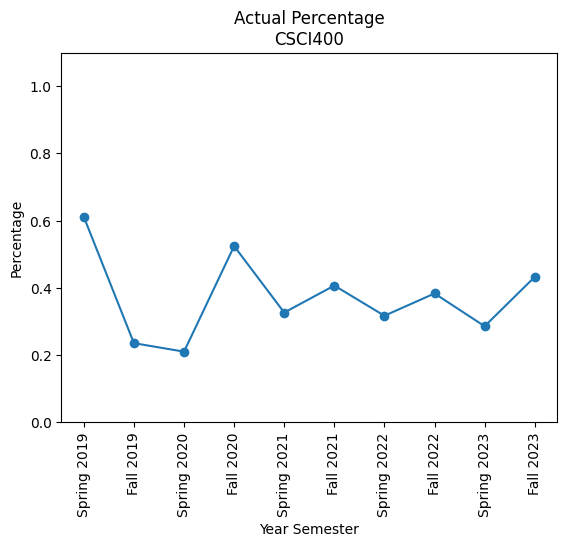

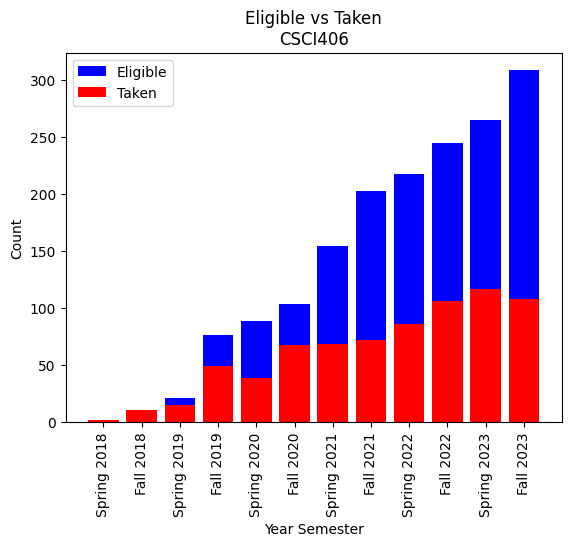

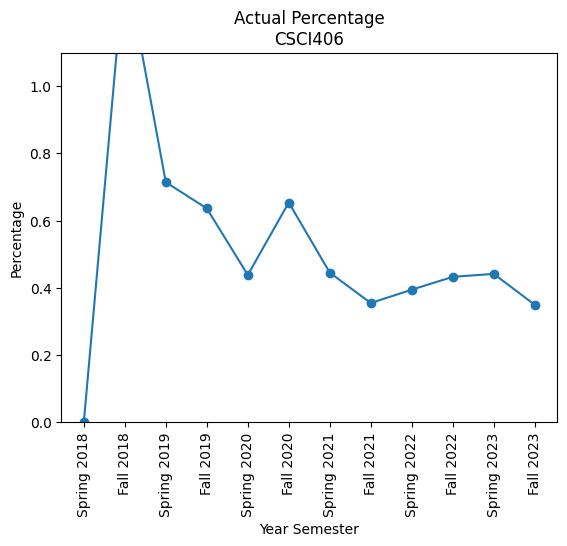

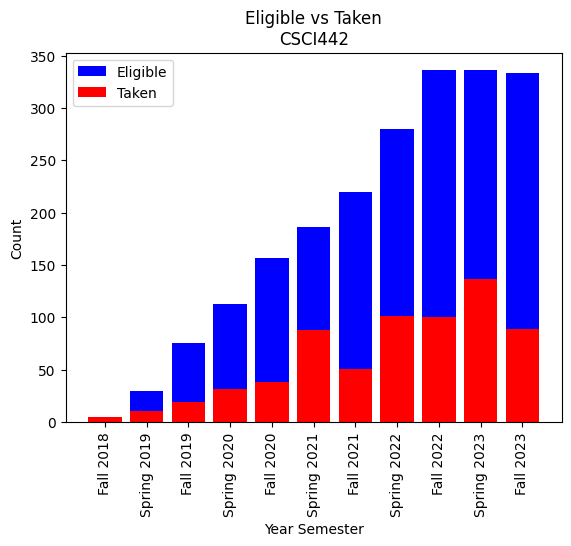

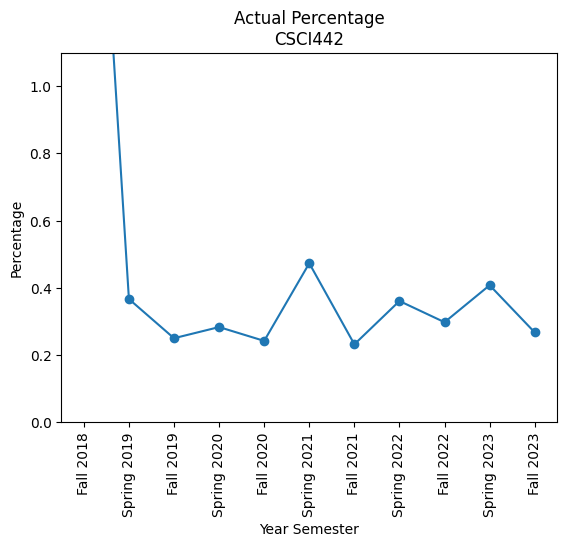

In [545]:
def plot_eligible_to_taken(carry_out, cl):

    # initialize 
    temp_carry = carry_out[['Year_Semester', cl]].copy()
    temp_taken = taken_df[taken_df['Class'] == cl].copy()
    temp_taken.loc[:, 'Year_Semester'] = temp_taken['Taken_Semester'] + ' ' + temp_taken['Taken_Year'].astype(str)
    eligible_dict = { sem:0 for sem in temp_taken['Year_Semester'].unique() }
    taken_dict = {sem: len(temp_taken[temp_taken['Year_Semester'] == sem]) for sem in temp_taken['Year_Semester'].unique()}

    # find eligible
    for ys in eligible_dict.keys():
        eligible_dict[ys] = len(temp_carry[(temp_carry['Year_Semester'] == ys) & (temp_carry[cl] == 0)])
    
    # find actual enrollment
    actual_dict = {sem:0 for sem in temp_taken['Year_Semester'].unique()}

    # print('=====\n', cl, actual_dict, "\n", cl, eligible_dict)
    
    # find actual eligibility
    for sem in actual_dict.keys(): 
        if eligible_dict[sem] != 0:
            actual_dict[sem] = taken_dict[sem] / eligible_dict[sem]
        else:
            actual_dict[sem] = 0

    # First, sort the DataFrame by 'Semester_Num'
    sorted_df = temp_taken.sort_values(by='Taken_Num')

    # Then, select the 'Year_Semester' column and get its unique values
    semester_list = sorted_df['Year_Semester'].unique()
    
    # maintain order
    ordered_actual_dict = {k: actual_dict[k] for k in semester_list}
    order_eligible_dict = {k: eligible_dict[k] for k in semester_list}
    order_taken_dict = {k: taken_dict[k] for k in semester_list}

    # plot hist
    plt.bar(order_eligible_dict.keys(), order_eligible_dict.values(), color='b', label='Eligible')
    plt.bar(order_taken_dict.keys(), order_taken_dict.values(), color='r', label='Taken')
    plt.xlabel('Year Semester')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.title(f'Eligible vs Taken\n{cl}')
    plt.legend()
    plt.show()

    # plot line graph of actual
    plt.plot(ordered_actual_dict.keys(), ordered_actual_dict.values(), marker='o')
    plt.xlabel('Year Semester')
    plt.ylabel('Percentage')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=90)
    plt.title(f'Actual Percentage\n{cl}')
    plt.show()

for cl in in_degrees.keys():
    plot_eligible_to_taken(carry_out, cl)
    